### 1.2.1 : EDA: Advanced Feature Extraction.


In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer #try with snowball stemmer also
from bs4 import BeautifulSoup
!pip install distance
import distance
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud,STOPWORDS
from os import path
from PIL import Image
!pip install fastparquet

     |████████████████████████████████| 152 kB 2.8 MB/s 
     |████████████████████████████████| 59 kB 5.1 MB/s 
  Created wheel for fastparquet: filename=fastparquet-0.3.3-cp36-cp36m-linux_x86_64.whl size=253676 sha256=26c5e755c82effaf4c9cc6d6e3cca038f9ac5beca5fac62afd54543ffcff3c45
  Stored in directory: /root/.cache/pip/wheels/17/0b/fe/81b4ce36e4b0abb7220e29ea450ac345efb6219b9ac888e5c9
  Created wheel for thrift: filename=thrift-0.13.0-cp36-cp36m-linux_x86_64.whl size=345244 sha256=4e48360579a39c0cca58c5e3307398dbcb1f2e3b4e2721c448b15072f18aa857
  Stored in directory: /root/.cache/pip/wheels/e0/38/fc/472fe18756b177b42096961f8bd3ff2dc5c5620ac399fce52d
Successfully built fastparquet thrift


* **We'll not use the below imported file for further processing, we'll use original**

In [0]:
#if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Models/Quora/qstn_train_without_preprocessing.csv'):
#  qstns_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Models/Quora/qstn_train_without_preprocessing.csv',encoding='latin-1')
#  qstns_train=qstns_train.fillna('')
#else:
#  print('Get the file from drive which already saved in above path or run the previous notebook')

###Importing the data file

In [2]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
     |████████████████████████████████| 1.4MB 2.8MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 1.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72859 sha256=11186545ba26dd553ce2167426c7268b2a294538585370b08288160ac3734abc
  Stored in directory: /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01
Successfully built kaggle
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.6/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.6/dist-packages/kaggle/api/kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure

In [0]:
def reading_file():
  
  !mkdir ~/.kaggle
  !touch ~/.kaggle/kaggle.json

  api_token = {"username":"vinodkumar9576","key":"af074010bd4c7bb75f9d1fe71f31452d"}

  import json

  with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

  !chmod 600 ~/.kaggle/kaggle.json

  !kaggle competitions download -c quora-question-pairs

# To find the list of file names in zip file
#for name in zip_file.namelist():
#    print ('%s' % (name))
#zip_file.close()

#Found this code snipper for reading files in a zipfile within a zipfile.
#https://stackoverflow.com/questions/11930515/unzip-nested-zip-files-in-python?noredirect=1&lq=1

  import zipfile
  from io import BytesIO
  import re

  with zipfile.ZipFile('/content/quora-question-pairs.zip', "r") as z:
    with z.open('train.csv.zip') as z2:
      z2_filedata = BytesIO(z2.read())
      with zipfile.ZipFile(z2_filedata) as nested_zip:
        qstns_train = pd.read_csv(nested_zip.open('train.csv'))
    with z.open('test.csv.zip') as z3:
      z3_filedata = BytesIO(z3.read())
      with zipfile.ZipFile(z3_filedata) as nested_zip2:
        qstns_test = pd.read_csv(nested_zip2.open('test.csv'),dtype = {"test_id":object,"question1":object,"question2":object})

#print("qstns_train :",end='\n')
#print(qstns_train.head(2))
#print("qstns_test :",end='\n')
#print(qstns_test.head(2))

In [0]:
#qstns_train.head(3)

<h2> 3.4 Preprocessing of Text </h2>

* **Preprocessing**
  
  * Removing html tags
  * Removing Punctuations
  * Expanding contractions etc.
  * Changing to lower case
  * Performing Stemming
  * Removing Stopwords

In [4]:
# Writing function that has all above preprocessings
SAVE_DIV = 0.0001 # to avoid divide by zero
#Below stores stop words
import nltk
nltk.download('stopwords')
STOP_WORDS = stopwords.words('english')

def decontracted(phrase):
  #specific
  phrase = re.sub(r"won\'t","will not",phrase)
  phrase = re.sub(r"can\'t","can not", phrase)

  #general
  phrase = re.sub(r"n\'t"," not", phrase)
  phrase = re.sub(r"\'re"," are",phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  phrase = re.sub(r'[₹]+', r' rupee ',phrase)
  phrase = re.sub(r'[$]+', r' dollar ',phrase)
  phrase = re.sub(r'[€]+', r' euro ',phrase)
  return phrase

def preprocessing(x):
  x = x.lower()
  #To Remove links
  x = re.sub(r"http\S+","",x)
  #To remove html tags
  x = BeautifulSoup(x,'lxml').get_text()
  #To expand short words to full
  x = decontracted(x)
  #To remove alphanumeric chars
  x = re.sub(r"\S*\d\S*","",x).strip()
  #To remove special characters
  x = re.sub(r"[^A-Za-z]+"," ",x).strip()
  #To make reviews lower case
  x = re.sub(r'([0-9]+)000000',r'\1m',x)
  x = re.sub(r'([0-9]+)000',r'\1k',x)
  
  # for stemming
  porter = PorterStemmer()
  if type(x)==type(''):
    x = porter.stem(x)
  
  return x


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:

* **Token** : Get it when you split a sentence by space
* **Stop_word** : words which are in stop word pool as per NLTK.
* **Word** : A token that is not a stop_word

Features:

 * **cwc_min** : Ratio of common_word_count to max_length of word count of Q1 and Q2 in each row. <br> cwc_min = common_word_count/min(len(n_words_q1),len(n_words_q2))
 * **cwc_max** : Ratio of common_word_count to max_length of no. of words in Q1 and Q2.<br> cwc_max = common_word_count/max(len(n_words_q1),len(n_words_q2))
 *  **csc_min** : Ratio of common stop words count to min_length of no. of words in Q1 and Q2. <br> csc_min = common_stop_words_count/min(len(q1_stops),len(q2_stops))
 * **csc_max** : Ratio of common stop words count to max_length of no. of words in Q1 and Q2. <br> csc_max = common_stop_words_count/max(len(q1_stops),len(q2_stops))
 * **ctc_min** : Ratio of common_token_count to min_length of no. of words in Q1 and Q2. <br> ctc_min = common_token_count/min(len(q1_tokens),len(q2_tokens))
 * **ctc_max** : Ratio of common_token_count to max_length of no. of words in Q1 and Q2. <br> ctc_max = common_token_count/max(len(q1_tokens),len(q2_tokens))
 * **last_word_eq** : Check if last word of both questions is equal or not. <br> last_word_eq = int(q1_tokens[-1]==q2_tokens[-1])
 * **first_word_eq** : Check if first word of both questions is equal or not. <br> first_word_eq = int(q1_tokens[0]==q1_tokens[0])
 * **abs_len_diff** : Absolute difference of no. of tokens of Q1 & Q2. <br> abs_len_diff = abs(len(q1_tokens)-len(q2_tokens))
 * **mean_len** : Average of total number of tokens in Q1 & Q2.<br> mean_len = (len(q1_tokens)+len(q2_tokens))/2
 * **fuzz_ratio** :
 * **fuzz_partial_ratio** :
 * **token_sort_ratio** : Tokenizing the string in question , sort them alphabetically and then join them to a string and then compare the transformed strings with a simple ratio().
 * **token_set_ratio** :
 * **longest_substr_ratio** : Ratio of length of longest common substring of Q1 & Q2 to min of token counts of Q1 & Q2.<br> longest_substr = len(longest_common_substring)/min(len(q1_tokens),len(q2_tokens))

In [0]:
def get_token_features(q1,q2):
  #Replicating the list of 0.0 10 times
  SAFE_DIV = 0.0001 # to avoid divide by zero
  token_features = [0.0]*10

  #Convertin the sentence into tokens
  q1_tokens = q1.split()
  q2_tokens = q2.split()

  if (len(q1_tokens) == 0 or len(q2_tokens) ==0):
    return token_features
  
  #Get the non-stop words in Questions
  q1_non_stops = set([word for word in q1_tokens if word not in STOP_WORDS])
  q2_non_stops = set([word for word in q2_tokens if word not in STOP_WORDS])

  #Get the stop words in questions, here we are just counting the stop words from the tokens
  # of Q1 and Q2 and not removing the stop words from questions itself.
  
  q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
  q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

  #Get the count of no. of common non-stop words
  common_non_stop_count = len(q1_non_stops & q2_non_stops)

  #Get the count of no. of common stop words
  common_stops_count = len(q1_stops & q2_stops)

  # Get the count of no. of common tokens from q1 and q2
  common_token_count = len(set(q1_tokens) & set(q2_tokens))

  # Till mean length there are 10 features and we are storing them in token_features list

  token_features[0] = common_non_stop_count / (min(len(q1_non_stops),len(q2_non_stops)) + SAFE_DIV)
  token_features[1] = common_non_stop_count / (max(len(q1_non_stops),len(q2_non_stops))+ SAFE_DIV)
  token_features[2] = common_stops_count / (min(len(q1_stops),len(q2_stops)) + SAFE_DIV)
  token_features[3] = common_stops_count / (min(len(q1_stops),len(q2_stops)) + SAFE_DIV)
  token_features[4] = common_token_count / (min(len(q1_tokens),len(q2_tokens)) + SAFE_DIV)
  token_features[5] = common_token_count / (min(len(q1_tokens),len(q2_tokens)) + SAFE_DIV)

  #checking if last word of both q1 & q2 is same
  token_features[6] = int(q1_tokens[-1]==q2_tokens[-1])

  #checking if first word of both q1 & q2 is same
  token_features[7] = int(q1_tokens[0]==q2_tokens[0])

  #Absolute difference of no. of tokens of Q1 & Q2.
  token_features[8] = abs(len(q1_tokens)-len(q2_tokens))

  # Average of total number of tokens in Q1 & Q2.
  token_features[9] = (len(q1_tokens) + len(q2_tokens))/2

  return token_features


###Function to get the longest common substring

In [0]:
# Get the longest common sub string

def get_longest_substr_ratio(a,b):
  strs = list(distance.lcsubstrings(a,b))
  if len(strs) == 0:
    return 0
  else:
    return len(strs[0]) / (min(len(a), len(b)) + 1)

###Main function to extract features

In [0]:
def extract_features(qstns_train):
  #preprocessing each question
  qstns_train['question1'] = qstns_train['question1'].fillna('').apply(preprocessing)
  qstns_train['question2'] = qstns_train['question2'].fillna('').apply(preprocessing)

  print('token features..', end=' ')

  # Merging features with dataset

  token_features = qstns_train.apply(lambda x: get_token_features(x['question1'],x['question2']), axis=1)

  # Adding token_features[] to our dataframe
  qstns_train['cwc_min'] = list(map(lambda x:x[0], token_features))
  qstns_train['cwc_max'] = list(map(lambda x:x[1], token_features))
  qstns_train['csc_min'] = list(map(lambda x:x[2], token_features))
  qstns_train['csc_max'] = list(map(lambda x:x[3], token_features))
  qstns_train['ctc_min'] = list(map(lambda x:x[4], token_features))
  qstns_train['ctc_max'] = list(map(lambda x:x[5], token_features))
  qstns_train['last_word_eq'] = list(map(lambda x:x[6], token_features))
  qstns_train['first_word_eq'] = list(map(lambda x:x[7], token_features))
  qstns_train['abs_len_diff'] = list(map(lambda x:x[8], token_features))
  qstns_train['mean_len'] = list(map(lambda x:x[9], token_features))

  #Computing Fuzzy Features and Merging with Dataset

  print('Fuzzy features..')

  qstns_train['token_set_ratio'] = qstns_train.apply(lambda x: fuzz.token_set_ratio(x['question1'], x['question2']), axis =1)
  qstns_train['token_sort_ratio'] = qstns_train.apply(lambda x: fuzz.token_sort_ratio(x['question1'], x['question2']), axis = 1)
  qstns_train['fuzz_ratio'] = qstns_train.apply(lambda x: fuzz.QRatio(x['question1'], x['question2']), axis =1)
  qstns_train['fuzz_partial_ratio'] = qstns_train.apply(lambda x: fuzz.partial_ratio(x['question1'], x['question2']), axis =1)
  qstns_train['longest_substr_ratio'] = qstns_train.apply(lambda x: get_longest_substr_ratio(x['question1'], x['question2']), axis = 1)

  return qstns_train

* Original train file is imported into qstns_train

###Driver program to process the data

In [8]:
reading_file() # function that reads data file from kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 96% 298M/309M [00:03<00:00, 57.1MB/s]
100% 309M/309M [00:03<00:00, 104MB/s] 


In [11]:
if os.path.isfile('/content/drive/My Drive/Colab Notebooks/Models/Quora/qstn_train_adv_ft.parquet.gzip'):
  qstns_train = pd.read_parquet('/content/drive/My Drive/Colab Notebooks/Models/Quora/qstn_train_adv_ft.parquet.gzip',engine='fastparquet')
  qstns_train=qstns_train.fillna('')
else:
  print('Extracting features for train:')
  #now we are going to use the original train file here... not the previously processed/saved file.
  qstns_train = extract_features(qstns_train)
  qstns_train.to_parquet('/content/drive/My Drive/Colab Notebooks/Models/Quora/qstn_train_adv_ft.parquet.gzip', compression='gzip')

qstns_train.head(2)



,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.916659,0.0,1.0,2.0,13.0,100,93,93,100,0.982456
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.749981,0.699993,0.699993,0.0,1.0,5.0,12.5,86,63,65,73,0.571429


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

* Creating word cloud of Duplicates and Non - Duplicates question pairs
* We can observe the most frequent occuring words.

In [35]:
qstns_train_dups = qstns_train[qstns_train['is_duplicate']==1]
qstns_train_non_dups = qstns_train[qstns_train['is_duplicate'] == 0]

p = np.dstack([qstns_train_dups['question1'], qstns_train_dups['question2']]).flatten()
n = np.dstack([qstns_train_non_dups['question1'], qstns_train_non_dups['question2']]).flatten()

print('No. of data points in class 1 (duplicate pairs) :', len(p))
print('No. of data points in class 0 (non duplicate pairs):', len(n))

#Saving the np array into a text file
np.savetxt('/content/drive/My Drive/Colab Notebooks/Models/Quora/qstns_train_p.txt',p, delimiter=' ', fmt='%s')
np.savetxt('/content/drive/My Drive/Colab Notebooks/Models/Quora/qstns_train_n.txt',n, delimiter =' ', fmt='%s')

No. of data points in class 1 (duplicate pairs) : 298526
No. of data points in class 0 (non duplicate pairs): 510054


* **Reading the text file and removing the stop words and picturing it.**
* **Not modifying the original questions data**

Total no. of words in duplicate pair question: 15205368
Toal no. of words in non duplicate pari question: 31360154
 
Word Cloud for Duplicate Question paris :


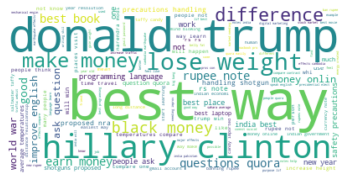

 
Word cloud generated for Non Duplicate question pairs


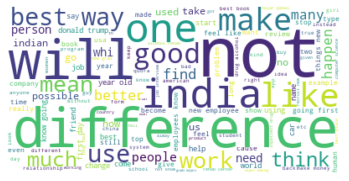

In [37]:
#d = path.dirname('.')

textp_w = open('/content/drive/My Drive/Colab Notebooks/Models/Quora/qstns_train_p.txt').read()
textn_w = open('/content/drive/My Drive/Colab Notebooks/Models/Quora/qstns_train_n.txt').read()

#Modifying the stop words set
stopwords = set(STOPWORDS)
stopwords.add('said')
stopwords.add('br')
stopwords.add(' ')

#removing negation words from stopwords set.
stopwords.remove('not')
stopwords.remove('no')
#removing positive words from stopwords set.
stopwords.remove('like')

print('Total no. of words in duplicate pair question:',len(textp_w))
print('Toal no. of words in non duplicate pari question:', len(textn_w))
print(' ')

##Word cloud generated from duplicate pair question's text##

wc = WordCloud(background_color = 'white', max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print('Word Cloud for Duplicate Question paris :')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

##Word cloud generated for Non Duplicate question pairs##

wc = WordCloud(background_color='white', max_words = len(textn_w),stopwords=stopwords)
wc.generate(textn_w)
print(' ')
print('Word cloud generated for Non Duplicate question pairs')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

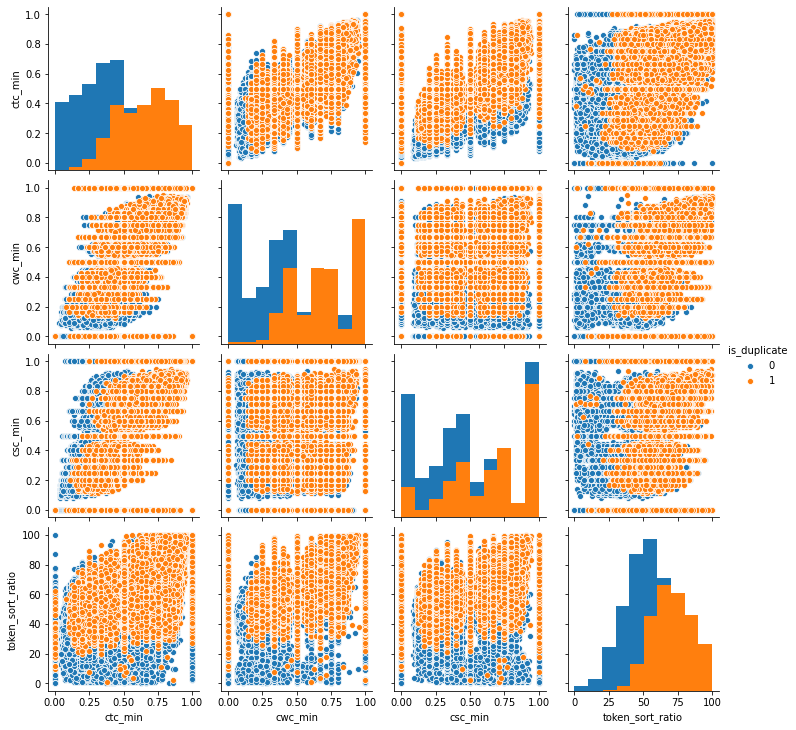

In [0]:
n = qstns_train.shape[0]
sns.pairplot(qstns_train[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio','is_duplicate']], diag_kind='hist', hue ='is_duplicate',vars= ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

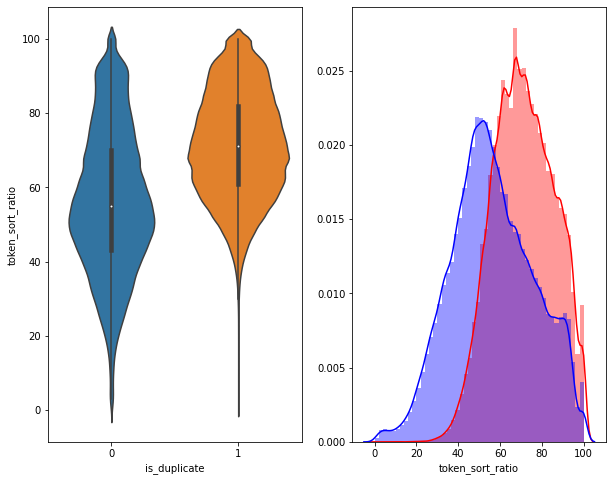

In [0]:
#Plotting distribution of token_sort_ratio

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='token_sort_ratio',data=qstns_train)

plt.subplot(1,2,2)
sns.distplot(qstns_train[qstns_train['is_duplicate']==1.0]['token_sort_ratio'],label='1',color ='red')
sns.distplot(qstns_train[qstns_train['is_duplicate']==0.0]['token_sort_ratio'], label='0', color='blue')
plt.show()

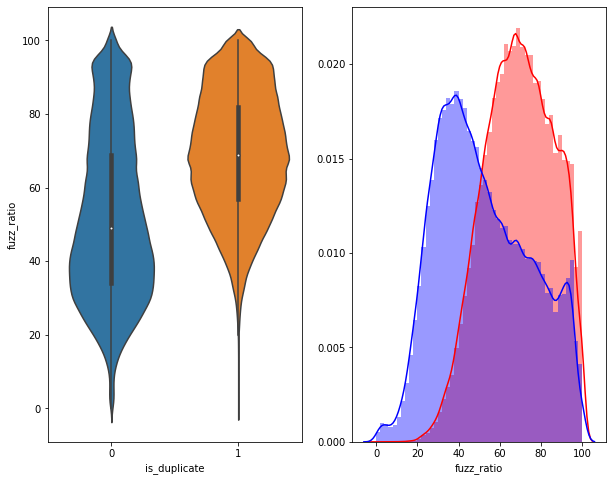

In [0]:
#Plotting distribution of fuzz_ratio vs is_duplicate

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='fuzz_ratio',data=qstns_train)

plt.subplot(1,2,2)
sns.distplot(qstns_train[qstns_train['is_duplicate']==1.0]['fuzz_ratio'],label='1',color ='red')
sns.distplot(qstns_train[qstns_train['is_duplicate']==0.0]['fuzz_ratio'], label='0', color='blue')
plt.show()

<h3>3.5.2 Visualization </h3>

* Using TSNE for dimensionality reduction of 15 features (nlp features) to 3 features.

In [0]:
#performing TSNE on first 5K rows as TSNE takes long time

from sklearn.preprocessing import MinMaxScaler

qstns_train_subsampled = qstns_train[0:5000]

X = MinMaxScaler().fit_transform(qstns_train_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
Y = qstns_train_subsampled['is_duplicate'].values

In [0]:
#We'll visualize nlp features reducing them to two features

tsne2d = TSNE(n_components=2,
              init = 'random', #pca
              random_state=101,
              method='barnes_hut',
              n_iter=1000,
              verbose=2,
              angle=0.5).fit_transform(X )

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 0.371s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.115649
[t-SNE] Computed conditional probabilities in 0.313s
[t-SNE] Iteration 50: error = 80.7513809, gradient norm = 0.0383682 (50 iterations in 2.234s)
[t-SNE] Iteration 100: error = 69.5449677, gradient norm = 0.0095275 (50 iterations in 1.667s)
[t-SNE] Iteration 150: error = 67.4025116, gradient norm = 0.0063583 (50 iterations in 1.755s)
[t-SNE] Iteration 200: error = 66.4557953, gradient norm = 0.0044986 (50 iterations in 1.854s)
[t-SNE] Iteration 250: error = 65.8946304, gradient norm = 0.0044327

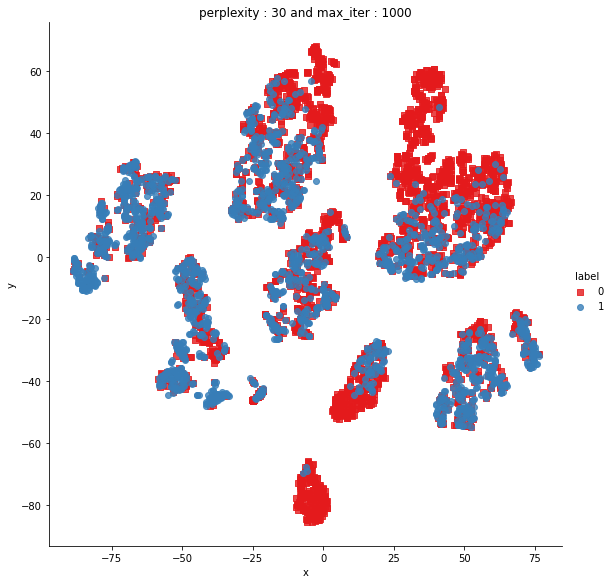

In [0]:
qstns_train_2d_ft = pd.DataFrame({'x':tsne2d[:,0],'y':tsne2d[:,1], 'label':Y})

#draw the plot in the appropriate place in the grid
sns.lmplot(data = qstns_train_2d_ft, x='x', y='y', hue='label', fit_reg=False, size =8, palette ='Set1',markers=['s','o'])
plt.title('perplexity : {} and max_iter : {}'.format(30,1000))
plt.show()

In [0]:
#Applying tsne for getting 3 features
qstns_train_3d_ft = TSNE(n_components=3,
              init='random',
              random_state=101,
              method='barnes_hut',
              n_iter=1000,
              verbose = 2,
              angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.019s...
[t-SNE] Computed neighbors for 5000 samples in 0.397s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.115649
[t-SNE] Computed conditional probabilities in 0.312s
[t-SNE] Iteration 50: error = 79.8656387, gradient norm = 0.0320888 (50 iterations in 8.892s)
[t-SNE] Iteration 100: error = 67.8254852, gradient norm = 0.0036005 (50 iterations in 4.507s)
[t-SNE] Iteration 150: error = 66.1966858, gradient norm = 0.0018392 (50 iterations in 3.980s)
[t-SNE] Iteration 200: error = 65.5490265, gradient norm = 0.0012448 (50 iterations in 3.943s)
[t-SNE] Iteration 250: error = 65.1800461, gradient norm = 0.0009818

In [0]:
trace1 = go.Scatter3d(x=qstns_train_3d_ft[:,0],
                      y=qstns_train_3d_ft[:,1],
                      z=qstns_train_3d_ft[:,2],
                      mode='markers',
                      marker=dict(
                          sizemode='diameter',
                          color=Y,
                          colorscale = 'Portland',
                          colorbar = dict(title='dupicate'),
                          line=dict(color='rgb(255,255,255)'),
                          opacity=0.75)
                      )
data =[trace1]
layout=dict(height=800,width=800,title='3d embeddig with ebgineered features')
fig=dict(data=data,layout=layout)
py.iplot(fig,filename='3DBubble')

In [0]:
from tqdm import trange
from colorama import Fore


for i in trange(int(7e7),
                bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
    pass

100%|██████████| 70000000/70000000 [00:14<00:00, 4820976.30it/s]


In [0]:
pip install colorama